In [156]:
import os
import torch
# import snntorch as snn
import matplotlib.pyplot as plt
# from snntorch import surrogate
# from snntorch import spikegen
# from snntorch import functional
# from snntorch import LIF
# from snntorch import spikeplot as splt
import pandas as pd
import numpy as np
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init

In [ ]:
# Dataset generated from 
torch.manual_seed(2)
# 假设您的数据形状是 (N, T, F)，其中 T=250 (时间步), F=700 (特征/神经元)

class SHDAugmentationDataset(data.Dataset):
    """
    针对 SHD 数据集的时间序列增强 (Random Time Shift)
    """
    def __init__(self, X_data: np.ndarray, y_data: np.ndarray, max_shift: int = 10, is_train: bool = True):
        """
        :param X_data: 脉冲数据 (N, T, F)
        :param y_data: 标签数据 (N,)
        :param max_shift: 最大随机平移时间步 (例如 10 步)
        :param is_train: 是否启用增强 (测试集不应增强)
        """
        super().__init__()
        self.X = torch.Tensor(X_data)
        self.y = torch.Tensor(y_data)
        self.max_shift = max_shift
        self.is_train = is_train
        self.T = self.X.shape[1] # 总时间步长 T (例如 250)
        self.max_jitter=3
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone() # 复制数据，避免修改原始 tensor
        y = self.y[idx]

        if self.is_train and self.max_shift > 0:
            # 1. 确定随机平移量 (例如 [-10, 10])
            shift = torch.randint(-self.max_shift, self.max_shift + 1, (1,)).item()
            
            # 2. 创建一个空的张量来存放平移后的数据
            x_shifted = torch.zeros_like(x)
            
            if shift > 0:
                # 向后平移 (shift > 0): [0, T-shift) 移到 [shift, T)
                # 开头 shift 步填充 0
                x_shifted[shift:] = x[:-shift]
            elif shift < 0:
                # 向前平移 (shift < 0): [-shift, T) 移到 [0, T+shift)
                # 结尾 |shift| 步填充 0
                abs_shift = abs(shift)
                x_shifted[:-abs_shift] = x[abs_shift:]
            else:
                # shift = 0，不平移
                x_shifted = x
                
            x = x_shifted
        #     mask_ratio = 0.05 # 随机掩蔽 5% 的神经元
        #     num_neurons = 700 # 700
            
        #     # 随机选择要掩蔽的神经元ID
        #     num_mask = int(num_neurons * mask_ratio)
        #     mask_indices = torch.randperm(num_neurons)[:num_mask]
            
        #     # 沿特征维度 (F) 对所有时间步的脉冲置零
        #     # x 形状: (T, F)
        #     x[:, mask_indices] = 0.0
            
            
        #     # 1. 找到所有脉冲的位置 (t, f)
        #     # indices 形状为 (2, Num_spikes)
        #     indices = x.nonzero(as_tuple=False) 
            
        #     if indices.shape[0] > 0:
        #         # 2. 为每个脉冲生成一个随机抖动量 (例如 [-3, 3])
        #         num_spikes = indices.shape[0]
        #         # jitter_t 形状为 (Num_spikes,)
        #         jitter_t = torch.randint(-self.max_jitter, self.max_jitter + 1, (num_spikes,)).to(x.device)
                
        #         # 3. 计算新的时间索引
        #         old_t = indices[:, 0]
        #         new_t = old_t + jitter_t
                
        #         # 4. 限制新索引在 [0, T-1] 范围内
        #         new_t = torch.clamp(new_t, 0, self.T - 1)
                
        #         # 5. 神经元 ID (特征轴) 保持不变
        #         f_indices = indices[:, 1]
                
        #         # 6. 创建一个新的零张量
        #         x_jittered = torch.zeros_like(x)
                
        #         # 7. 在新的时间点重新设置脉冲
        #         # 这是一个高效的索引操作：在 (new_t, f_indices) 处设置 1.0
        #         x_jittered[new_t, f_indices] = 1.0
                
        #         x = x_jittered
        return x, y
train_X = np.load('data/trainX_4ms.npy')
train_y = np.load('data/trainY_4ms.npy').astype(np.float64)

test_X = np.load('data/testX_4ms.npy')
test_y = np.load('data/testY_4ms.npy').astype(np.float64)

print('dataset shape: ', train_X.shape) #(shape stands for number of samples, time steps, number of neurons / features)
print('dataset shape: ', test_X.shape) #(shape stands for number of samples, time steps, number of neurons / features)

tensor_trainX = torch.Tensor(train_X)  # transform to torch tensor
tensor_trainY = torch.Tensor(train_y)


train_dataset = SHDAugmentationDataset(train_X, train_y, max_shift=10, is_train=True)
# train_dataset = data.TensorDataset(tensor_trainX, tensor_trainY)
train_loader = data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
tensor_testX = torch.Tensor(test_X)  # transform to torch tensor
tensor_testY = torch.Tensor(test_y)

sorted_idx = torch.argsort(tensor_testY)
sorted_X = tensor_testX[sorted_idx]
sorted_Y = tensor_testY[sorted_idx]


test_dataset = data.TensorDataset(sorted_X, sorted_Y)
test_loader = data.DataLoader(test_dataset, batch_size = 32, shuffle=False)

dataset shape:  (8156, 250, 700)
dataset shape:  (2264, 250, 700)


In [563]:
ain_dataset = SHDAugmentationDataset(train_X, train_y, max_shift=10, is_train=True)
# train_dataset = data.TensorDataset(tensor_trainX, tensor_trainY)
train_loader = data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
tensor_testX = torch.Tensor(test_X)  # transform to torch tensor
tensor_testY = torch.Tensor(test_y)
test_dataset = data.TensorDataset(tensor_testX, tensor_testY)
test_loader = data.DataLoader(test_dataset, batch_size = 64, shuffle=False)

In [990]:
test_dataset = data.TensorDataset(sorted_X, sorted_Y)
test_loader = data.DataLoader(test_dataset, batch_size = 48, shuffle=False)

In [991]:
import torch.nn as nn
class CustomLoss_task(nn.Module):

    def __init__(self, target_firing_rate=0.02,target_synchrony=1.4, target_branching=1.0,batch_size=25):
        super(CustomLoss_task, self).__init__()
        self.target_synchrony = torch.tensor([target_synchrony] * batch_size, requires_grad=True)
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
        self.target_branching = torch.tensor([target_branching] * batch_size,requires_grad=True)
        self.criterion_classification = nn.CrossEntropyLoss()

    def forward(self, outputs, targets, firing_rate, synchrony_fano_factor, criticality):

        w_task = 1
        task_loss = self.criterion_classification(outputs, targets)
        self.task_loss = task_loss

        self.rate_loss = torch.tensor([0])
        self.criticality_loss = torch.tensor([0])
        self.synchrony_loss = torch.tensor([0])

        total_loss = w_task*task_loss 
        return total_loss

class CustomLoss_task_rate(nn.Module):

    def __init__(self, target_firing_rate=0.02, target_synchrony=1.4, target_branching=1.0,batch_size=25):
        super(CustomLoss_task_rate, self).__init__()
        self.target_synchrony = torch.tensor([target_synchrony] * batch_size, requires_grad=True)
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
        self.target_branching = torch.tensor([target_branching] * batch_size,requires_grad=True)
        self.criterion_classification = nn.CrossEntropyLoss()

    def forward(self, outputs, targets, criticality, firing_rate, synchrony_fano_factor):
        w_rate = 0
        w_task = 1
        
        task_loss = self.criterion_classification(outputs, targets)
        rate_loss = nn.MSELoss()(firing_rate,self.target_firing_rate)

        self.task_loss = task_loss
        self.rate_loss = rate_loss

        self.criticality_loss = torch.tensor([0])
        self.synchrony_loss = torch.tensor([0])

        total_loss = w_task*task_loss + w_rate*rate_loss
        return total_loss
    
class CustomLoss_task_sync(nn.Module):

    def __init__(self,target_firing_rate=0.02,  target_synchrony=1.4, target_branching=1.0,batch_size=25):
        super(CustomLoss_task_sync, self).__init__()
        self.target_synchrony = torch.tensor([target_synchrony] * batch_size, requires_grad=True)
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
        self.target_branching = torch.tensor([target_branching] * batch_size,requires_grad=True)
        self.criterion_classification = nn.CrossEntropyLoss()

    def forward(self, outputs, targets, criticality, firing_rate, synchrony_fano_factor):
        w_sync = 0
        w_task = 1
        
        task_loss = self.criterion_classification(outputs, targets)
        synchrony_loss = nn.MSELoss()(synchrony_fano_factor,self.target_synchrony)

        self.task_loss = task_loss
        self.synchrony_loss = synchrony_loss

        self.rate_loss = torch.tensor([0])
        self.criticality_loss = torch.tensor([0])

        total_loss = w_task*task_loss + w_sync*synchrony_loss
        return total_loss

class CustomLoss_task_criticality(nn.Module):

    def __init__(self, target_firing_rate=0.02, target_synchrony=1.4,target_branching=1.0,batch_size=25):
        super(CustomLoss_task_criticality, self).__init__()
        self.target_synchrony = torch.tensor([target_synchrony] * batch_size, requires_grad=True)
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
        self.target_criticality = torch.tensor([target_branching] * batch_size,requires_grad=True)
        self.criterion_classification = nn.CrossEntropyLoss()

    def forward(self, outputs, targets, criticality, firing_rate, synchrony_fano_factor):
        w_crit = 0
        w_task = 1
        
        task_loss = self.criterion_classification(outputs, targets)
        criticality_loss = nn.MSELoss()(criticality,self.target_criticality)

        self.task_loss = task_loss
        self.criticality_loss = criticality_loss

        self.rate_loss = torch.tensor([0])
        self.synchrony_loss = torch.tensor([0])

        total_loss = w_task*task_loss + w_crit*criticality_loss
        return total_loss
    
class CustomLoss_all(nn.Module):

    def __init__(self, target_firing_rate=0.02, target_synchrony=1.4, target_branching=1.0,batch_size=25):
        super(CustomLoss_all, self).__init__()
        self.target_synchrony = torch.tensor([target_synchrony] * batch_size, requires_grad=True)
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
        self.target_branching = torch.tensor([target_branching] * batch_size,requires_grad=True)
        self.criterion_classification = nn.CrossEntropyLoss()

    def forward(self, outputs, targets, criticality, firing_rate, synchrony_fano_factor):

        w_crit = 0
        w_rate = 0
        w_sync = 0
        w_task = 1
        
        task_loss = self.criterion_classification(outputs, targets)
        rate_loss = nn.MSELoss()(firing_rate, self.target_firing_rate)
        criticality_loss = nn.MSELoss()(criticality,self.target_branching)
        synchrony_loss = nn.MSELoss()(synchrony_fano_factor,self.target_synchrony)

        self.task_loss = task_loss
        self.rate_loss = rate_loss
        self.criticality_loss = criticality_loss
        self.synchrony_loss = synchrony_loss

        total_loss = w_task*task_loss + w_rate*rate_loss + w_crit*criticality_loss + w_sync*synchrony_loss
        return total_loss

In [ ]:
import torch.nn as nn
class sigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        if x.requires_grad:
            ctx.save_for_backward(x)
            ctx.alpha = 4.0
        return x.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        grad_x = None
        if ctx.needs_input_grad[0]:
            sgax = (ctx.saved_tensors[0] * ctx.alpha).sigmoid_()
            grad_x = grad_output * (1. - sgax) * sgax * ctx.alpha

        return grad_x, None

class quant1(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # output = torch.where(input >= 3, 4.0, torch.where(input >= 1.5, 2.0,  torch.where(input >= 0.5, 1.0, 0)))
        # return torch.round(torch.clamp(input, min=0, max=1))
        return torch.where(input>0,1.,0)
        # return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        #             print("grad_input:",grad_input)
        grad_input[input < -0.7] = 0
        grad_input[input > 0.7] = 0
        return grad_input
class quant4(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # output=torch.where(input >=3,4,torch.where(input>=1.5,2,torch.where(input>=0.75,1,torch.where(input>=0.375,0.5,torch.where(input>=0.125,0.25,0)))))
        # output = torch.where(input >= 3, 4.0, torch.where(input >= 1.5, 2.0,  torch.where(input >= 0.5, 1.0, 0)))
        return torch.round(torch.clamp(input, min=0, max=4))
        # return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        #             print("grad_input:",grad_input)
        grad_input[input < 0] = 0
        grad_input[input > 4.0] = 0
        return grad_input
class MultiStepLIFNode(nn.Module):
    def __init__(self,tau,channle=None ,v_threshold=1,):
        super().__init__()
        self.spike_fn = sigmoid.apply
        # self.leak=nn.Parameter(torch.ones(T))
        # self.input = nn.Parameter(torch.ones(T))
        self.v_threshold =v_threshold
        self.sig=nn.Sigmoid()
        # self.layers=layers
        if channle!=None:
            self.input=nn.Parameter(torch.ones([tau,channle]))
            self.leake = nn.Parameter(torch.ones([tau,channle]))
        else:
                
            self.input=nn.Parameter(torch.ones([tau]))
            self.leake = nn.Parameter(torch.ones([tau]))
        # 2. 适应变量衰减常数 gamma
        self.gamma = nn.Parameter(torch.tensor(1.))
        # 3. 适应变量增量 beta
        self.beta = nn.Parameter(torch.tensor(1.))
        # print("大家好我是第{}层".format(self.layers))
    def forward(self,mem,x_seq: torch.Tensor,t=0):

        # B,_,N=x_seq.shape
   
        leake_=self.leake[t].tanh()
        input_=self.input[t].tanh()
        spike_seq = []
        if len(x_seq.size())==3:
            leake_=leake_.unsqueeze(0).unsqueeze(-1)
            input_=input_.unsqueeze(0).unsqueeze(-1)
        if len(x_seq.size())==2:
            leake_=leake_.unsqueeze(-1) 
            input_=input_.unsqueeze(-1) 
   
        if t == 0:
            mem =leake_* x_seq
        else:

            mem = leake_*mem.detach() + input_*x_seq

        x= self.spike_fn( mem-self.v_threshold)
        mem=mem-x.detach()

        
        return mem,x

In [ ]:
class RSNN3(nn.Module):
    def __init__(self):
        super(RSNN3, self).__init__()
        num_inputs = 700
        num_hidden = 64
        self.num_output = 20
        beta = 0.85
        pe_e = 0.16
        timestep=250
        self.con1_out=16
        self.con2_out=32
        self.l1 = nn.Conv1d(7,self.con1_out,11,5)
        self.l1bn = nn.GroupNorm(self.con1_out, self.con1_out)
        self.lif1=MultiStepLIFNode(timestep,self.con1_out)
        
        self.l2 =  nn.Conv1d(self.con1_out,self.con2_out,7,5)
        self.l2bn = nn.GroupNorm(self.con2_out, self.con2_out)
        self.lif2=MultiStepLIFNode(timestep,self.con2_out)
        
        self.l5= nn.Linear(96,self.num_output)
        
        self.offset = nn.Parameter(torch.rand([timestep,self.con1_out+self.con2_out]))
        
        self.relu=nn.ReLU()
        self.spike_fn = sigmoid.apply
        
    def forward(self, inputs,epoch):
        # print(inputs.shape)
        # inputs=inputs.transpose(0,1)
        # print(inputs.shape)
        B, T , L = inputs.shape
        inputs=inputs.transpose(0,1).reshape(T,B,7,100)# T ,  B, L
        loss=0
        # mem1=torch.zeros([B,1,175]).cuda()
        # mem2=torch.zeros_like(inputs[0]).cuda()
        mem1=0
        mem2=0
        output=torch.zeros([T,B,self.num_output]).cuda()
       
        ch_ex=torch.zeros([T,B,self.con1_out+self.con2_out]).cuda()
        for t in range(T):
            x=self.l1(inputs[t])
            mem1,x=self.lif1(mem1,x,t)
            x=self.l2(x)
            mem2,x1=self.lif2(mem2,x,t)
            x=self.l5(x1.reshape(B,-1))         
            output[t]=x
                
                

        return output,ch_ex.mean()


In [ ]:
import random


def seed_all(seed=1029):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
seed_all(35)
# model = RSNN3()
model=torch.load("0.139_91.61_dy_best",weights_only=False)
criterion = CustomLoss_all()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)
num_timesteps = 250
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model.to(device)

device: cuda:0


RSNN3(
  (l1): Conv1d(7, 16, kernel_size=(11,), stride=(5,))
  (l1bn): GroupNorm(16, 16, eps=1e-05, affine=True)
  (lif1): MultiStepLIFNode(
    (sig): Sigmoid()
  )
  (l2): Conv1d(16, 32, kernel_size=(7,), stride=(5,))
  (l2bn): GroupNorm(32, 32, eps=1e-05, affine=True)
  (lif2): MultiStepLIFNode(
    (sig): Sigmoid()
  )
  (l5): Linear(in_features=96, out_features=20, bias=True)
  (lifcontro): Linear(in_features=96, out_features=48, bias=True)
  (lifcontrobn): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (controlif): MultiStepLIFNode(
    (sig): Sigmoid()
  )
  (lifcontro2): Linear(in_features=48, out_features=48, bias=True)
  (relu): ReLU()
)

In [ ]:
input_grad = []
rec_grad = []
output_grad = []
save_spikes =[]

In [ ]:
# sci_mode=False 强制关闭科学计数法
# precision=4 设置小数点后保留 4 位
torch.set_printoptions(sci_mode=False, precision=4)
def train(model, num_epochs):
    epoch_losses =[]
    acc = []
    best=0
    train_best=0
    sch=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs,eta_min=2e-4)
    best_pr=1
    for epoch in range(1, num_epochs):
        # if epoch<50:
        #     sch.step()
        #     continue
        
        predicted_outputs =[]
        total_spikes = []
        epoch_loss = 0.0
        correct = 0
        total = 0
        sigh=0
        cha_ex=0
        model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
            sigh=sigh+1
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            inputs = inputs.requires_grad_(True)
            # outputs = []
            predictions =[]
          

            output,loss2= model(inputs,epoch)
            cha_ex+=loss2.item()
            

            _, predicted = torch.max(output.mean(0).data, -1) # Get the predicted class (maximum value) from the output
            predictions.append(predicted)

            predicted_outputs = torch.cat(predictions).squeeze()
            correct += (predicted_outputs.eq(labels)).sum().item()  # Compare predicted class with the true label and update the 
            
            labels = labels.long()
            if epoch<0:

                loss = nn.CrossEntropyLoss()(output.mean(0), labels)+(0.15*(epoch/30))*(loss2-0.3).pow(2)
            else:
                loss = nn.CrossEntropyLoss()(output.mean(0), labels)+10*(loss2-0.001).pow(2)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()  
            total += labels.size(0)
            accuracy = 100. * correct / total

            acc.append(accuracy)
            # total_spikes= torch.stack(spikes_per_batch)
        print(f'train:Epoch [{epoch}/{num_epochs}],  Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
     
        model.eval()
        correct = 0
        total = 0
        sigh=0
        cha_ex=0
        # 1. 初始化每个类别的统计器 (SHD 数据集有 20 类)
        num_classes = 20
        class_correct = torch.zeros(num_classes).to(device)
        class_total = torch.zeros(num_classes).to(device)
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(test_loader):
                sigh+=1
                # print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
                inputs=inputs.to(device)
                labels=labels.to(device)
                optimizer.zero_grad()
            
                unique_labels, counts = torch.unique(labels, return_counts=True)
        
                predictions =[]
                spikes_per_batch = []


                output,_ = model(inputs,epoch)
                

                cha_ex+=_
                _, predicted = torch.max(output.mean(0).data, -1) # Get the predicted class (maximum value) from the output
                predictions.append(predicted)
                predicted_outputs = torch.cat(predictions).squeeze()
                correct += (predicted_outputs.eq(labels)).sum().item()  # Compare predicted class with the true label and update the 
                total += labels.size(0)
                accuracy = 100. * correct / total
                # 3. 计算每个种类的准确率
                for i in range(len(labels)):
                    label = labels[i].long()
                    if predicted[i] == label:
                        class_correct[label] += 1
                    class_total[label] += 1
                # 
            # 打印每个种类的正确率
            print("-" * 30)
            print(f"Epoch [{epoch}] 各类别准确率分析:")
            for i in range(num_classes):
                if class_total[i] > 0:
                    cls_acc = 100 * class_correct[i] / class_total[i]
                    print(f"类别 {i:2d}: {cls_acc:6.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
                else:
                    print(f"类别 {i:2d}: 无数据")
            

       
            if accuracy>best:
                best=accuracy
                torch.save(model,"dy_best")
            print(best)
            print("-" * 30)
            sch.step()


    plt.figure(figsize=(10,6))
    plt.plot(range(1, num_epochs +1), epoch_losses, marker = 'o')
    plt.title('Loss Change Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    return acc

In [ ]:
acc = train(model, num_epochs) 

------------------------------
Epoch [1] 各类别准确率分析:
类别  0:  92.23% (95/103)
类别  1:  99.07% (107/108)
类别  2:  58.10% (61/105)
类别  3:  78.43% (80/102)
类别  4:  99.14% (115/116)
类别  5:  93.64% (103/110)
类别  6:  98.17% (107/109)
类别  7:  99.08% (108/109)
类别  8:  92.11% (105/114)
类别  9: 100.00% (103/103)
类别 10:  96.72% (118/122)
类别 11:  97.52% (118/121)
类别 12:  77.69% (94/121)
类别 13:  91.67% (110/120)
类别 14:  97.39% (112/115)
类别 15:  95.54% (107/112)
类别 16:  79.66% (94/118)
类别 17:  79.34% (96/121)
类别 18:  99.19% (122/123)
类别 19:  52.68% (59/112)
测试路径选择激活率 (cha_ex): 0.13547256588935852
test:Epoch [1/100], Accuracy: 88.96%
88.95759717314488
------------------------------


KeyboardInterrupt: 

In [ ]:
# 假设你已经收集了 20 个类别的 tensor，存放在一个 list 里
class_data = [
    [    0.4618,     0.4790,     0.2732,     0.0000,     0.2146,     0.1495,
            0.4063,     0.0000,     0.0119,     0.5476,     0.3085,     0.1993,
            0.0069,     0.0593,     0.3313,     0.1791,     0.0972,     0.3312,
            0.1561,     0.0372,     0.1217,     0.1023,     0.0001,     0.0899,
            0.0302,     0.1728,     0.1833,     0.4902,     0.1616,     0.0983,
            0.0727,     0.1355,     0.3297,     0.1257,     0.2566,     0.2139,
            0.1862,     0.1379,     0.1791,     0.1802,     0.0751,     0.2122,
            0.0631,     0.1198,     0.0989,     0.1216,     0.2818,     0.1152],
    [0.3451, 0.4128, 0.2297, 0.0000, 0.1123, 0.1115, 0.2455, 0.0000, 0.0016,
        0.4807, 0.4487, 0.0654, 0.0008, 0.0608, 0.2697, 0.1299, 0.0787, 0.4923,
        0.1076, 0.0161, 0.1356, 0.1042, 0.0009, 0.0914, 0.0078, 0.0837, 0.1262,
        0.3038, 0.1205, 0.1412, 0.0642, 0.1264, 0.2044, 0.2439, 0.1812, 0.1984,
        0.1138, 0.1129, 0.1462, 0.1230, 0.0208, 0.1511, 0.0584, 0.0562, 0.1552,
        0.1225, 0.1962, 0.1405],
    [0.2828, 0.4690, 0.2062, 0.0000, 0.1895, 0.1624, 0.3347, 0.0000, 0.0323,
        0.4002, 0.2575, 0.1335, 0.0172, 0.0123, 0.3582, 0.0452, 0.0230, 0.2845,
        0.1395, 0.0686, 0.0940, 0.0351, 0.0000, 0.0223, 0.1778, 0.1277, 0.1315,
        0.2387, 0.2444, 0.1101, 0.0206, 0.0800, 0.0913, 0.1161, 0.2072, 0.2397,
        0.2228, 0.1238, 0.1439, 0.0786, 0.1172, 0.0076, 0.0097, 0.1138, 0.0765,
        0.0389, 0.1297, 0.0737],
    [    0.2889,     0.3947,     0.2150,     0.0000,     0.1682,     0.0568,
            0.3284,     0.0000,     0.0039,     0.3690,     0.3178,     0.1165,
            0.0019,     0.0103,     0.2537,     0.1046,     0.0219,     0.3369,
            0.1587,     0.0290,     0.0841,     0.0744,     0.0003,     0.0554,
            0.2142,     0.0929,     0.1826,     0.2514,     0.2028,     0.0955,
            0.0232,     0.1089,     0.1174,     0.1743,     0.1492,     0.1841,
            0.1607,     0.1112,     0.1490,     0.1137,     0.0416,     0.0197,
            0.0368,     0.0596,     0.1653,     0.0571,     0.1113,     0.0724],
    [    0.3397,     0.3341,     0.1941,     0.0000,     0.1139,     0.2313,
            0.2331,     0.0000,     0.0039,     0.4435,     0.3687,     0.0954,
            0.0095,     0.0306,     0.2867,     0.0306,     0.0206,     0.3083,
            0.0408,     0.0362,     0.1186,     0.0428,     0.0002,     0.0140,
            0.0382,     0.0640,     0.1372,     0.5415,     0.1142,     0.2162,
            0.0101,     0.0686,     0.2725,     0.1123,     0.2024,     0.1752,
            0.1943,     0.1162,     0.0662,     0.0865,     0.0599,     0.0319,
            0.0111,     0.0467,     0.1770,     0.2131,     0.2643,     0.2075],
    [0.3067, 0.2442, 0.1432, 0.0000, 0.0903, 0.2123, 0.2062, 0.0000, 0.0023,
        0.4557, 0.4753, 0.0234, 0.0030, 0.0050, 0.2149, 0.0148, 0.0153, 0.4183,
        0.0281, 0.0461, 0.1203, 0.0843, 0.0000, 0.0107, 0.0425, 0.0538, 0.1123,
        0.5163, 0.1322, 0.1361, 0.0072, 0.1347, 0.1429, 0.1689, 0.1023, 0.1052,
        0.2003, 0.0992, 0.0742, 0.0758, 0.0646, 0.0072, 0.0056, 0.0541, 0.1842,
        0.1014, 0.1423, 0.2263],
    [    0.1963,     0.4492,     0.1323,     0.0000,     0.1702,     0.0908,
            0.3871,     0.0001,     0.0183,     0.4705,     0.5179,     0.0077,
            0.0439,     0.0049,     0.2598,     0.0042,     0.0092,     0.0547,
            0.0281,     0.2408,     0.1273,     0.0203,     0.0000,     0.0014,
            0.2485,     0.0720,     0.1838,     0.1149,     0.0949,     0.2297,
            0.0041,     0.0455,     0.1388,     0.0278,     0.0875,     0.0324,
            0.5055,     0.1436,     0.1157,     0.0642,     0.4060,     0.0017,
            0.0017,     0.1945,     0.0882,     0.0739,     0.0851,     0.0568],
    [0.2005, 0.4262, 0.1176, 0.0000, 0.1237, 0.1607, 0.2615, 0.0000, 0.0113,
        0.4717, 0.4560, 0.0467, 0.0282, 0.0054, 0.2378, 0.0067, 0.0214, 0.3792,
        0.0267, 0.1058, 0.1033, 0.0229, 0.0000, 0.0079, 0.0311, 0.0768, 0.1391,
        0.2454, 0.1221, 0.1513, 0.0602, 0.0645, 0.1956, 0.1866, 0.1237, 0.2198,
        0.2436, 0.1167, 0.1130, 0.0637, 0.1702, 0.0078, 0.0021, 0.1182, 0.0930,
        0.0463, 0.1022, 0.1346],
    [    0.2688,     0.3282,     0.1832,     0.0000,     0.1061,     0.0954,
            0.3269,     0.0000,     0.0011,     0.3293,     0.4270,     0.0719,
            0.0112,     0.0087,     0.1974,     0.0419,     0.0033,     0.2483,
            0.1353,     0.0556,     0.0337,     0.0595,     0.0001,     0.0247,
            0.3759,     0.0878,     0.1643,     0.1123,     0.2023,     0.1608,
            0.0118,     0.0803,     0.0669,     0.2061,     0.1968,     0.0983,
            0.2012,     0.0885,     0.2050,     0.0757,     0.1884,     0.0035,
            0.0097,     0.0358,     0.2751,     0.0492,     0.0335,     0.0718],
    [0.4024, 0.3853, 0.2052, 0.0000, 0.1221, 0.1527, 0.2593, 0.0000, 0.0006,
        0.4947, 0.3782, 0.0467, 0.0010, 0.0539, 0.2481, 0.1394, 0.1344, 0.4119,
        0.0954, 0.0162, 0.1070, 0.1335, 0.0016, 0.0577, 0.0033, 0.0934, 0.1443,
        0.5112, 0.0985, 0.1059, 0.0417, 0.1524, 0.2462, 0.2422, 0.2128, 0.1932,
        0.1243, 0.1062, 0.1086, 0.1341, 0.0232, 0.2387, 0.0724, 0.0631, 0.1847,
        0.0742, 0.2548, 0.1499],
    [0.4309, 0.3985, 0.3153, 0.0000, 0.1622, 0.1036, 0.3695, 0.0000, 0.0012,
        0.4629, 0.2741, 0.2120, 0.0010, 0.0719, 0.3077, 0.1864, 0.0793, 0.3407,
        0.1657, 0.0168, 0.1612, 0.1374, 0.0010, 0.0927, 0.0671, 0.1184, 0.2099,
        0.4053, 0.1294, 0.1166, 0.0389, 0.1191, 0.2275, 0.1113, 0.2462, 0.1887,
        0.1394, 0.1462, 0.1263, 0.1644, 0.0247, 0.1924, 0.0895, 0.0848, 0.1466,
        0.2304, 0.2796, 0.1102],
    [    0.2447,     0.2613,     0.1264,     0.0000,     0.0424,     0.0577,
            0.2236,     0.0000,     0.0003,     0.3763,     0.4031,     0.0143,
            0.0069,     0.0058,     0.1759,     0.0055,     0.0021,     0.3548,
            0.0475,     0.0512,     0.0912,     0.1366,     0.0000,     0.0036,
            0.0940,     0.0282,     0.0617,     0.2533,     0.1181,     0.1324,
            0.0084,     0.1896,     0.0827,     0.2589,     0.0658,     0.1298,
            0.1630,     0.0573,     0.0987,     0.0355,     0.0574,     0.0037,
            0.0017,     0.0385,     0.2125,     0.0917,     0.0898,     0.1600],
    [    0.2862,     0.3956,     0.1617,     0.0000,     0.1492,     0.2048,
            0.2948,     0.0000,     0.0155,     0.5359,     0.4747,     0.0443,
            0.0189,     0.0106,     0.2622,     0.0247,     0.0372,     0.4212,
            0.0448,     0.1114,     0.1412,     0.0278,     0.0002,     0.0162,
            0.0414,     0.1016,     0.1639,     0.3682,     0.1278,     0.1778,
            0.0132,     0.0970,     0.1989,     0.1745,     0.1553,     0.1662,
            0.2507,     0.1356,     0.1154,     0.0774,     0.1608,     0.0527,
            0.0074,     0.1409,     0.1165,     0.0602,     0.1460,     0.1567],
    [    0.3842,     0.4248,     0.2142,     0.0000,     0.1170,     0.1661,
            0.2591,     0.0000,     0.0020,     0.5352,     0.4731,     0.0695,
            0.0024,     0.0308,     0.2517,     0.0901,     0.0347,     0.4278,
            0.0784,     0.0250,     0.1233,     0.0922,     0.0001,     0.0398,
            0.0132,     0.0853,     0.1358,     0.4341,     0.1226,     0.1552,
            0.0319,     0.1388,     0.2421,     0.2659,     0.1682,     0.1707,
            0.1851,     0.1352,     0.1124,     0.1377,     0.0672,     0.0841,
            0.0420,     0.0781,     0.2153,     0.0787,     0.1967,     0.2004],
    [0.2772, 0.4351, 0.1750, 0.0000, 0.2240, 0.0905, 0.3835, 0.0000, 0.0153,
        0.5006, 0.3982, 0.1357, 0.0012, 0.0238, 0.2812, 0.1037, 0.0545, 0.2747,
        0.1511, 0.0478, 0.0669, 0.0320, 0.0000, 0.0488, 0.1014, 0.1783, 0.1942,
        0.2727, 0.1713, 0.0769, 0.0143, 0.0932, 0.1658, 0.1151, 0.2027, 0.1542,
        0.2252, 0.0766, 0.1718, 0.1189, 0.0609, 0.1339, 0.0237, 0.0873, 0.1125,
        0.1313, 0.1783, 0.0650],
    [0.2147, 0.3637, 0.1697, 0.0000, 0.1530, 0.1784, 0.3088, 0.0000, 0.0072,
        0.3686, 0.4575, 0.0427, 0.0030, 0.0088, 0.2239, 0.0245, 0.0247, 0.3591,
        0.0600, 0.0519, 0.0890, 0.0302, 0.0000, 0.0117, 0.3615, 0.0850, 0.1701,
        0.2722, 0.2119, 0.1182, 0.0047, 0.0850, 0.0777, 0.1558, 0.1142, 0.2033,
        0.3252, 0.1072, 0.1261, 0.0924, 0.0729, 0.0038, 0.0082, 0.0622, 0.1049,
        0.0672, 0.1260, 0.1248],
    [0.3461, 0.3203, 0.2662, 0.0000, 0.1577, 0.0637, 0.3890, 0.0000, 0.0088,
        0.4577, 0.4352, 0.1050, 0.0058, 0.0088, 0.2559, 0.1538, 0.0412, 0.1687,
        0.1007, 0.0646, 0.1349, 0.1056, 0.0006, 0.0543, 0.1337, 0.1102, 0.2613,
        0.2526, 0.1067, 0.1669, 0.0237, 0.1106, 0.1747, 0.0852, 0.1957, 0.0281,
        0.2409, 0.1709, 0.1198, 0.1402, 0.1003, 0.0628, 0.0587, 0.0927, 0.2123,
        0.2584, 0.1968, 0.0857],
    [    0.4268,     0.4587,     0.2702,     0.0000,     0.2556,     0.0717,
            0.4689,     0.0000,     0.0093,     0.4672,     0.3847,     0.2318,
            0.0030,     0.0085,     0.3968,     0.2393,     0.0467,     0.3707,
            0.2558,     0.0327,     0.0857,     0.1365,     0.0003,     0.1708,
            0.0788,     0.1898,     0.1879,     0.2121,     0.2599,     0.0308,
            0.0623,     0.1642,     0.1581,     0.1886,     0.2409,     0.2125,
            0.1729,     0.1169,     0.2548,     0.2073,     0.0512,     0.1131,
            0.0913,     0.1121,     0.1567,     0.0516,     0.1478,     0.0435],
    [0.2674, 0.0827, 0.1097, 0.0000, 0.0359, 0.0562, 0.1823, 0.0000, 0.0005,
        0.2718, 0.2632, 0.0065, 0.0068, 0.0063, 0.1636, 0.0040, 0.0016, 0.1564,
        0.0157, 0.0553, 0.0927, 0.1373, 0.0000, 0.0025, 0.0706, 0.0203, 0.0532,
        0.3520, 0.0488, 0.1278, 0.0082, 0.1365, 0.0834, 0.0456, 0.0546, 0.0101,
        0.1433, 0.0597, 0.0283, 0.0314, 0.0542, 0.0014, 0.0019, 0.0353, 0.1882,
        0.1611, 0.0754, 0.1350],
    [0.3932, 0.4038, 0.2866, 0.0000, 0.1422, 0.1263, 0.2975, 0.0000, 0.0023,
        0.4986, 0.3974, 0.1360, 0.0012, 0.0742, 0.2652, 0.1532, 0.1481, 0.4186,
        0.1159, 0.0183, 0.1914, 0.1531, 0.0006, 0.0820, 0.0080, 0.0999, 0.2001,
        0.4297, 0.1120, 0.1758, 0.0497, 0.1312, 0.2423, 0.2130, 0.2077, 0.2097,
        0.1065, 0.1303, 0.1238, 0.1427, 0.0235, 0.2298, 0.0803, 0.0737, 0.1567,
        0.1735, 0.2723, 0.0962],
]

import pandas as pd

# 1. 直接创建 DataFrame，Pandas 会自动处理列表嵌套
df = pd.DataFrame(class_data)

# 2. 动态设置列名和行名
df.columns = [f'Ch_{i}' for i in range(df.shape[1])]
df.index = [f'Class_{i}' for i in range(df.shape[0])]

# 3. 导出为 CSV（用 WPS 打开这个文件）
df.to_csv("activation_matrix.csv")

print("转换成功！请打开 activation_matrix.csv 查看。")

转换成功！请打开 activation_matrix.csv 查看。


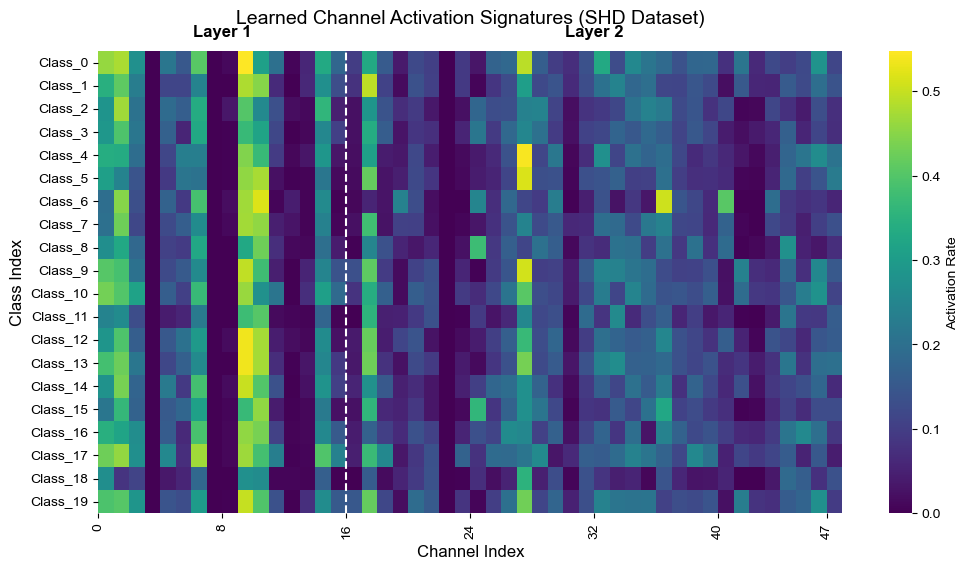

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 设置全局字体（论文通常要求 Arial 或 Times New Roman）
plt.rcParams['font.family'] = 'Arial'

# 设置画布比例，论文一般用比较修长的比例
plt.figure(figsize=(12, 6))

# 使用 Seaborn 绘制热力图
# cmap: 建议用 'viridis'（科研通用）或 'Blues'（蓝白配色，打印黑白论文也清晰）
# cbar_kws: 设置右侧色条的标签
ax = sns.heatmap(df, 
                 cmap="viridis",      # 科学配色
                 annot=False,         # 论文热力图通常不显示数字，靠颜色表达
                 linewidths=0,        # 去掉网格线，让画面更平滑
                 cbar_kws={'label': 'Activation Rate'})

# --- 关键学术标注 ---
# 1. 划分层级：在 Layer 1 (16ch) 和 Layer 2 (32ch) 之间画一条分界线
ax.axvline(16, color='white', linestyle='--', lw=1.5) 

# 2. 添加层级标签
ax.text(8, -0.5, 'Layer 1', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text(32, -0.5, 'Layer 2', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. 设置坐标轴刻度（不要每个都显示，每隔 5 或 10 个显示一个）
ax.set_xticks([0, 8, 16, 24, 32, 40, 47])
ax.set_xticklabels(['0', '8', '16', '24', '32', '40', '47'])

plt.title("Learned Channel Activation Signatures (SHD Dataset)", fontsize=14, pad=20)
plt.xlabel("Channel Index", fontsize=12)
plt.ylabel("Class Index", fontsize=12)

# 保存为高分辨率 PDF（投稿首选）或 600 DPI 的 PNG
plt.savefig("paper_heatmap.pdf", bbox_inches='tight', dpi=600)
plt.show()